In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from netCDF4 import Dataset
from cartopy.io import srtm
from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io.srtm import SRTM3Source, SRTM1Source
import pandas as pd
from matplotlib import colorbar, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import NearestNDInterpolator
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.ops import cascaded_union
from shapely.ops import unary_union
from geopy import distance
%matplotlib inline

In [2]:
wells = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/Wells_Data/Wells_Wlmt_Vly_mapsouth.csv')
lat = wells['Latitude']
lon = wells['Longitude']
depth = wells['Depth [m]']
wname = wells['SiteName']

PDB_lat = []
PDB_lon = []
PDB_vs30 = []
PDB_latlon = np.genfromtxt('/Users/rshimony/Desktop/WillametteValley/Vs_profiles_PDB/2016335_esupp/Table_S2_Oregon.csv',
                           delimiter=',',usecols=(4,5,7),skip_header=1)
for i in range(len(PDB_latlon)):
    plat = PDB_latlon[i][0]
    plon = PDB_latlon[i][1]
    pvs30 = PDB_latlon[i][2]
    PDB_lat.append(plat)
    PDB_lon.append(plon)
    PDB_vs30.append(pvs30)

print(max(lat))

44.5431213


In [3]:
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

In [71]:
vs30_file = '/Users/rshimony/Documents/Vs30_global/earthquake-global_vs30-master/PNW/pnw.grd'
water_file = '/Users/rshimony/Documents/Vs30_global/earthquake-global_vs30-master/PNW/landmask_water.grd'
land_file = '/Users/rshimony/Documents/Vs30_global/earthquake-global_vs30-master/PNW/landmask_land.grd'

vs30_grd = Dataset(vs30_file, 'r', format='NETCDF4')
water_grd = Dataset(water_file, 'r', format='NETCDF4')
land_grd = Dataset(land_file, 'r', format='NETCDF4')

lon_grd=vs30_grd.variables['lon'][290:400]
lat_grd=vs30_grd.variables['lat'][290:400]
vs30=vs30_grd.variables['z'][290:400 , 290:400]
water=water_grd.variables['z'][:]
land=land_grd.variables['z'][:]

# [-123.3,-122.7,43.8,44.4]

LON,LAT = np.meshgrid(lon_grd,lat_grd)

# def zero_to_nan(values):
#     """Replace every 0 with 'nan' and return a copy."""
#     return [float('nan') if x==0 else x for x in values]

# for i in range(len(water)):
#     water[i]=zero_to_nan(water[i])
    
    
# print((np.unique(vs30)))
print(vs30)
print(vs30.shape)
vs30_grd
# vs30_resam = np.resample(vs30,)

[[419. 419. 419. ... 419. 419. 419.]
 [419. 419. 419. ... 419. 419. 419.]
 [419. 419. 419. ... 419. 419. 419.]
 ...
 [419. 419. 419. ...  98.  98.  98.]
 [419. 419. 419. ...  98. 419. 419.]
 [419. 419. 419. ... 419. 419.  98.]]
(110, 110)


/var/folders/b9/lpn_b8pj1n7_m6yczj34v_080000gn/T/ipykernel_4660/1961838669.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon_grd=vs30_grd.variables['lon'][290:400]
/var/folders/b9/lpn_b8pj1n7_m6yczj34v_080000gn/T/ipykernel_4660/1961838669.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat_grd=vs30_grd.variables['lat'][290:400]
/var/fold

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    history: grdfilter -I30s -R-126/-116/41/50 -D0 -Fm0.016 waor_ext.grd -Gpnw.grd
    GMT_version: 6.1.1 [64-bit]
    dimensions(sizes): lon(1201), lat(1081)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float32 z(lat,lon)
    groups: 

In [5]:
gravity_file = '/Users/rshimony/Desktop/WillametteValley/gravity_data/gravity_an_cas.nc'
gravity_grd = Dataset(gravity_file, 'r', format='NETCDF4')

grav_lon_r = gravity_grd.variables['x_range'][:]
grav_lat_r = gravity_grd.variables['y_range'][:]
grav_elev_r = gravity_grd.variables['z_range'][:]
grav_spacing = gravity_grd.variables['spacing'][:]
grav_dim = gravity_grd.variables['dimension'][:]
grav_val = gravity_grd.variables['z'][:]
print(grav_lon_r)
print(grav_lat_r)
print(grav_elev_r)
print(grav_dim)
print(grav_spacing)
print(grav_val.shape)
# print(gravity_grd.variables)

lon_grav = np.arange(-126.36914062,-120.13769531,0.00878906)
lat_grav = np.arange(43.50393999,46.09761448,0.00623479)
LON_g,LAT_g = np.meshgrid(lon_grav,lat_grav)
print(LON_g.shape)

grav_val_reshaped = grav_val.reshape((710, 417))
min_grav_ind = np.where(grav_val_reshaped == grav_val_reshaped.min())
deep_grav_ind = np.where(grav_val_reshaped <= -75)
print(min_grav_ind[0][0])
print(grav_val_reshaped[111,374])
print(deep_grav_ind[0])
print(lon_grav[374])
print(lat_grav[111])

grav_75_lon = []
grav_75_lat = []

for i in deep_grav_ind[0]:
    lat_val = lat_grav[i]
    grav_75_lat.append(lat_val)
    
for i in deep_grav_ind[1]:
    lon_val = lon_grav[i]
    grav_75_lon.append(lon_val)

print(grav_75_lon)
print(grav_75_lat)

# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(LON_g,LAT_g,grav_val_reshaped,c=grav_val_reshaped,cmap='terrain',s=5)
# plt.show()
# ax.view_init(90, 0)

[-126.36914062 -120.13769531]
[43.50393999 46.09761448]
[-75.64122009 125.46176147]
[710 417]
[0.00878906 0.00623479]
(296070,)
(417, 710)
111
-75.64122009277344
[110 110 111 111 111 113 113]
-123.08203218000074
44.196001680000066
[-125.65722676000016, -125.64843770000016, -123.09082124000074, -123.08203218000074, -123.07324312000074, -124.18066468000049, -124.17187562000049]
[44.189766890000065, 44.189766890000065, 44.196001680000066, 44.196001680000066, 44.196001680000066, 44.20847126000007, 44.20847126000007]


/var/folders/b9/lpn_b8pj1n7_m6yczj34v_080000gn/T/ipykernel_4660/1915934279.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grav_lon_r = gravity_grd.variables['x_range'][:]
/var/folders/b9/lpn_b8pj1n7_m6yczj34v_080000gn/T/ipykernel_4660/1915934279.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grav_lat_r = gravity_grd.variables['y_range'][:

In [32]:
# plcarreeproj = ccrs.PlateCarree() 

# rect = [0,0,6,5] # left, bottom, width, height

# mapax = plt.axes(rect,projection=plcarreeproj)

# mapax.set_extent([-124.2,-121.5,43.8,45.75])

# mapax.background_img()
# # mapax.stock_img()

# mapax.coastlines()

# mapax.gridlines()

# plt.show()

In [83]:
stations = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/recorded_data/metadata/station_inventory_project.csv')
st_lat = stations['stlats']
st_lon = stations['stlon']
st_name = stations['stName']

# stations = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/salem_eq/metadata/station_inventory.csv')
# st_lat = stations['latitude']
# st_lon = stations['longitude']
# st_name = stations['name']

st_name[0]

'B027'

In [7]:
valley_poly = np.array([[-123.2641219775928,44.64634967360506],
               [-123.3774486537867,44.5216826327464],
               [-123.1301667224165,43.49355895349841],
               [-123.0758323132938,43.49353022525693],
               [-122.9903835522051,44.45484968462699],
               [-122.7948953662283,44.64386451064287],
               [-123.2641219775928,44.64634967360506]])

valley_poly.shape

(7, 2)

In [8]:
basin_poly_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/basin_poly.csv')

lon_poly = basin_poly_f['lon']
lat_poly = basin_poly_f['lat']

basin_poly = np.zeros((len(lon_poly),2))

for i in range(len(lon_poly)):
    basin_poly[i,0] = lon_poly[i]
    basin_poly[i,1] = lat_poly[i]
    

In [9]:
basin_depth_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/basin_depth_poly.csv')

lon_depth = basin_depth_f['lon']
lat_depth = basin_depth_f['lat']
depth = basin_depth_f['depth']

SRV_wells_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/SRV_wells.csv')

lon_SRV = SRV_wells_f['Longitude']
lat_SRV = SRV_wells_f['Latitude']
SRV = SRV_wells_f['srv_depth']

yamhill_wells_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/yamhill_wells.csv')

lon_yamhill = yamhill_wells_f['Longitude']
lat_yamhill = yamhill_wells_f['Latitude']
yamhill = yamhill_wells_f['yamhill_depth']

spencer_wells_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/spencer_wells.csv')

lon_spencer = spencer_wells_f['Longitude']
lat_spencer = spencer_wells_f['Latitude']
spencer = spencer_wells_f['Spencer_depth']

spen2eug_thick_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/spen2eug_thick.csv')

lon_spen2eug = spen2eug_thick_f['Longitude']
lat_spen2eug = spen2eug_thick_f['Latitude']
spen2eug_thick = spen2eug_thick_f['thickness_spen2eug']


In [10]:
depth2units_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/depth2units_wells.csv')

lon_units = depth2units_f['Longitude']
lat_units = depth2units_f['Latitude']
srv_depth = depth2units_f['srv_depth']
yamhill_depth = depth2units_f['yamhill_depth']
spencer_depth = depth2units_f['Spencer_depth']
eugene_depth = depth2units_f['eugene_depth']
thickness_srv2yam = depth2units_f['thickness_srv2yam']
thickness_yam2spen = depth2units_f['thickness_yam2spen']
thickness_spen2eug = depth2units_f['thickness_spen2eug']
thickness_yam2eug = depth2units_f['thickness_yam2eug']

unit_depths = [srv_depth , yamhill_depth , spencer_depth , eugene_depth]
unit_thicks = [thickness_srv2yam , thickness_yam2spen , thickness_spen2eug , thickness_yam2eug]

In [11]:
f_path = '/Users/rshimony/Desktop/zzthick4.axyz'

f = np.genfromtxt(f_path)

f_lat = []
f_lon = []
f_z = []

for i in range(len(f)):
    f_lon.append(f[i][0])
    f_lat.append(f[i][1])
    f_z.append(f[i][2])
   
# plt.figure()
# plt.scatter(f_lon , f_lat , c=f_z)

evdict = {'lon':f_lon, 'lat':f_lat , 'depth':f_z}
evdf = pd.DataFrame(evdict)
evdf.to_csv('/Users/rshimony/Desktop/WillametteValley/depth2base_tual.csv',index=False)

In [12]:
depth2base_tual_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/depth2units_wells/depth2base_tual.csv')

lon_tual = depth2base_tual_f['lon']
lat_tual = depth2base_tual_f['lat']
depth_tual = depth2base_tual_f['depth']

In [17]:
p2 = CS.allsegs
p1 = p2[0][:]
p1.sort(key = len , reverse=True)
poly = p1[2]
px = poly[:,0]
py = poly[:,1]

p = p1[2]
poly1 = Polygon(p)

print(len(p1))

poly_point1 = Point(-123.0616,44.84)
poly_point2 = Point(-123.1314,45.07)

# print(poly1.contains(poly_point))

cont_poly = []

for i in range(len(p1)):
    temp_poly = Polygon(p1[i])
    if temp_poly.contains(poly_point1) == True:
        cont_poly.append(temp_poly)
    elif temp_poly.contains(poly_point2) == True:
        cont_poly.append(temp_poly)
    
    
outer_poly = cont_poly[0]
inner_poly1 = cont_poly[1]
inner_poly2 = cont_poly[2]

# new_poly = outer_poly.difference(inner_poly1)

new_poly = Polygon(outer_poly.exterior.coords, [inner_poly1.exterior.coords , inner_poly2.exterior.coords])

xpn, ypn = new_poly.exterior.xy
xph1, yph1 = new_poly.interiors[0].xy
xph2, yph2 = new_poly.interiors[1].xy
# plt.figure(figsize=(8,10))
# plt.plot(xpn, ypn, c="red")
# plt.plot(xph1, yph1, c="red")
# plt.plot(xph2, yph2, c="red")

lons_newp = np.arange(-124.19,-121.51,0.015)
lats_newp = np.arange(43.4,46.7,0.015)

inpoly_lons = []
inpoly_lats = []

for i in lons_newp:
    for j in lats_newp:
        grd_point = Point(i,j)
        if new_poly.contains(grd_point) == True:
            inpoly_lons.append(i)
            inpoly_lats.append(j)

4699


In [18]:
o_poly_x ,  o_poly_y = outer_poly.exterior.xy
i1_poly_x ,  i1_poly_y = inner_poly1.exterior.xy
i2_poly_x ,  i2_poly_y = inner_poly2.exterior.xy

print(o_poly_x[0])

-123.31666666666666


In [481]:
# lon_g,lat_g = np.meshgrid(lons_newp,lats_newp)
# plt.figure(figsize=(15,15))
# plt.scatter(lon_g,lat_g,c='r')
# plt.scatter(inpoly_lons,inpoly_lats,c='b')
# plt.show()

In [19]:
xpnn = np.array([xpn])
xph1n = np.array([xph1])
xph2n = np.array([xph2])

ypnn = np.array([ypn])
yph1n = np.array([yph1])
yph2n = np.array([yph2])

xpnt = np.concatenate((xpnn, xph1n , xph2n), axis=1)
ypnt = np.concatenate((ypnn, yph1n , yph2n), axis=1)

xpnt[0][0]

-123.31666666666666

In [20]:
evdict_o = {'outer_lon':o_poly_x, 'outer_lat':o_poly_y}
evdf_o = pd.DataFrame(evdict_o)
evdf_o.to_csv('/Users/rshimony/Desktop/WillametteValley/basin_depth_poly_outer.csv',index=False)

evdict_i1 = {'inner1_lon':i1_poly_x, 'inner1_lat':i1_poly_y}
evdf_i1 = pd.DataFrame(evdict_i1)
evdf_i1.to_csv('/Users/rshimony/Desktop/WillametteValley/basin_depth_poly_inner1.csv',index=False)

evdict_i2 = {'inner2_lon':i2_poly_x, 'inner2_lat':i2_poly_y}
evdf_i2 = pd.DataFrame(evdict_i2)
evdf_i2.to_csv('/Users/rshimony/Desktop/WillametteValley/basin_depth_poly_inner2.csv',index=False)

In [12]:
dists = []
counter = 1

for i in range(len(inpoly_lats)):
    
    if counter % 10 == 0:
        print(str(counter) + ' from ' + str(len(inpoly_lats)))
    ds = []
    
    for j in range(len(xpnt[0])):
    
        coord_inpoly = (inpoly_lats[i] , inpoly_lons[i])
        coord_bpoly = (ypnt[0][j] , xpnt[0][j])

        d = distance.distance(coord_inpoly, coord_bpoly).km
        ds.append(d)
        
    d_min = min(ds)
    dists.append(d_min)
    counter = counter + 1

10 from 3742
20 from 3742
30 from 3742
40 from 3742
50 from 3742
60 from 3742
70 from 3742
80 from 3742
90 from 3742
100 from 3742
110 from 3742
120 from 3742
130 from 3742
140 from 3742
150 from 3742
160 from 3742
170 from 3742
180 from 3742
190 from 3742
200 from 3742
210 from 3742
220 from 3742
230 from 3742
240 from 3742
250 from 3742
260 from 3742
270 from 3742
280 from 3742
290 from 3742
300 from 3742
310 from 3742
320 from 3742
330 from 3742
340 from 3742
350 from 3742
360 from 3742
370 from 3742
380 from 3742
390 from 3742
400 from 3742
410 from 3742
420 from 3742
430 from 3742
440 from 3742
450 from 3742
460 from 3742
470 from 3742
480 from 3742
490 from 3742
500 from 3742
510 from 3742
520 from 3742
530 from 3742
540 from 3742
550 from 3742
560 from 3742
570 from 3742
580 from 3742
590 from 3742
600 from 3742
610 from 3742
620 from 3742
630 from 3742
640 from 3742
650 from 3742
660 from 3742
670 from 3742
680 from 3742
690 from 3742
700 from 3742
710 from 3742
720 from 3742
7

In [21]:
evdict1 = {'lon':inpoly_lons, 'lat':inpoly_lats , 'depth':dists}
evdf1 = pd.DataFrame(evdict1)
evdf1.to_csv('/Users/rshimony/Desktop/WillametteValley/basin_depth_poly_full.csv',index=False)

NameError: name 'dists' is not defined

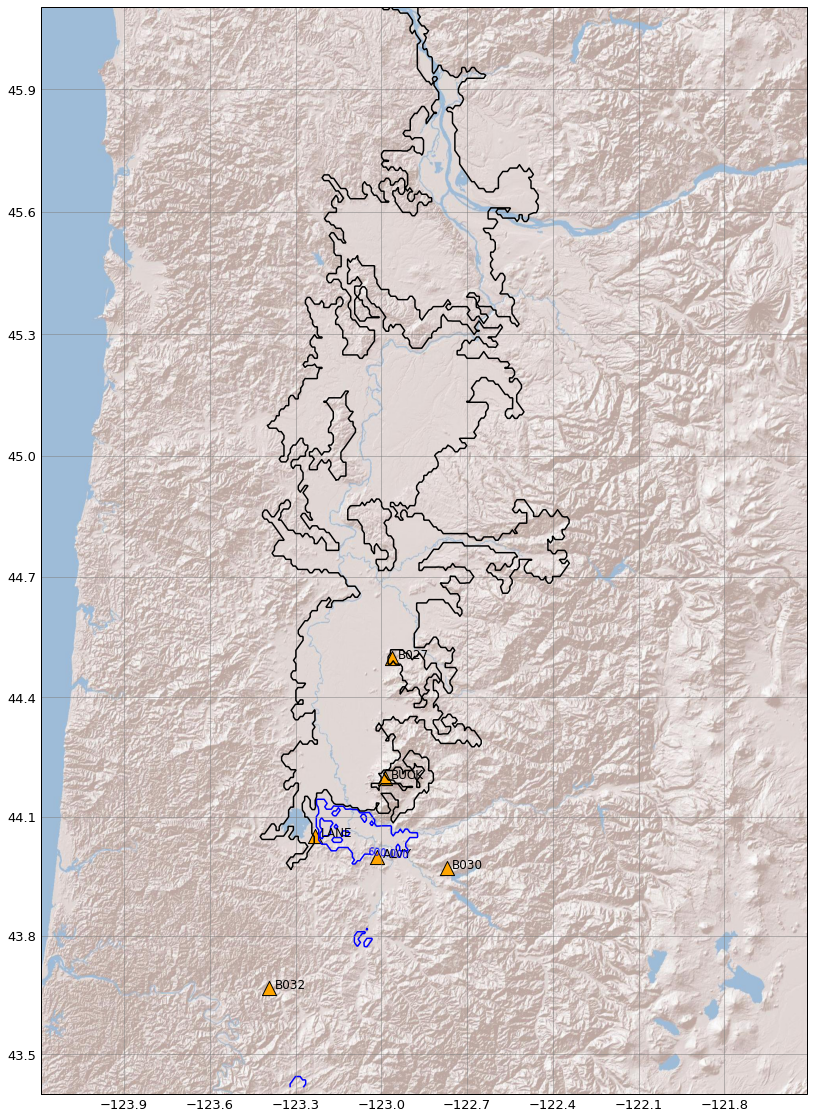

In [86]:
# plt.figure(figsize=(20, 10))
# imagery_url = 'https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg'
# # ctiles = cimgt.GoogleTiles(style='satellite')
# ctiles = cimgt.GoogleTiles(url=imagery_url , style='satellite')
# ax = plt.axes(projection=ctiles.crs)
# ax.set_extent([-124.19,-121.51,43.4,44.84])
# ax.add_image(ctiles,10, interpolation='spline36')

plt.figure(figsize=(15, 20))

ax = plt.axes(projection=ShadedReliefESRI().crs)
ax.set_extent([-124.19,-121.51,43.4,46.1])
ax.add_image(ShadedReliefESRI(), 10)

# ax.set_xticks([-124,-123,-122], crs=ccrs.PlateCarree())
# ax.set_yticks([44,44.5,45], crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)

gl_major = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl_major.xlabels_top = False
gl_major.ylabels_right = False
gl_major.xlabel_style = {'size': 13}
gl_major.ylabel_style = {'size': 13}
# gl_major.xlocator = mticker.FixedLocator(np.arange(-124.19,-121.49,0.5))
# gl_major.ylocator = mticker.FixedLocator(np.arange(43.4,45.74,0.5))

# scat=ax.scatter(lon,lat,s=200,c='whitesmoke',alpha=0.7,transform=ccrs.PlateCarree(),edgecolors='k')
# for n in range(len(wname)):
#     ax.text(lon[n]-0.10, lat[n]+0.03,str(wname[n]), fontsize=10, color='maroon', transform=ccrs.PlateCarree())
# handles, labels = scat.legend_elements(num=4,prop="sizes", alpha=0.6)
# legend = ax.legend(handles, ['500','1500','2500','3500'], loc="upper right", title="Depth [m]")

# sact2 = ax.scatter(-122.8334,44.0896, s=250 , c='yellow' , transform=ccrs.PlateCarree(),edgecolors='k', marker='*')

sact3 = ax.scatter(st_lon,st_lat, s=200 , c='orange' , transform=ccrs.PlateCarree(),edgecolors='k', marker='^')
for i in range(len(st_name)):
    ax.text(st_lon[i]+0.02, st_lat[i],str(st_name[i]), fontsize=12, color='k', transform=ccrs.PlateCarree())


# sact4 = ax.scatter(LON_g,LAT_g,c=grav_val,cmap='terrain' ,transform=ccrs.PlateCarree(),alpha=0.1)
# cb=plt.colorbar(sact4,fraction=0.035, pad=0.08)
# cb.set_alpha(1)
# cb.draw_all()

# scat2=ax.scatter(LON,LAT,c=vs30,cmap='Greys',alpha=0.1,transform=ccrs.PlateCarree() 
#                  ,vmin=0,vmax=vs30.max(), zorder=1)
# cb=plt.colorbar(scat2,fraction=0.035, pad=0.08)
# cb.set_alpha(1)
# cb.set_label('Vs30 - Global Model')
# cb.draw_all()

CS = ax.contour(LON,LAT,vs30,transform=ccrs.PlateCarree(),levels=[600],colors=['b'] , 
                extent=([-123.3,-122.7,43.8,44.4]))
ax.clabel(CS, inline=True, fontsize=10)

# CS1 = ax.tricontour(lon_yamhill,lat_yamhill,yamhill,transform=ccrs.PlateCarree(),colors=['b'],zorder=3)
# ax.clabel(CS1, inline=True, fontsize=10)

# CS2 = ax.tricontour(lon_tual,lat_tual,depth_tual,transform=ccrs.PlateCarree(),colors=['b'],zorder=3)
# ax.clabel(CS2, inline=True, fontsize=10)

# scat3=ax.scatter(LON,LAT,c=water,cmap='winter',alpha=0.4,transform=ccrs.PlateCarree(), zorder=2)

# scat4=ax.scatter(PDB_lon,PDB_lat,c=PDB_vs30,cmap='Paired', marker='D',vmin=0,vmax=max(PDB_vs30),
#                  transform=ccrs.PlateCarree(),edgecolors='k', zorder=4)
# cb=plt.colorbar(scat4,fraction=0.035, pad=0.04,orientation="horizontal")
# cb.set_label('Vs30 - PDB')

# rect = patches.Rectangle(xy=[-123.65, 43.49], width=1.15, height=1.16,linewidth=2.5,facecolor='none'
#                          ,edgecolor='grey',linestyle='--',transform=ccrs.PlateCarree())
# ax.add_patch(rect)

# valley_borders = patches.Polygon(xy=valley_poly,facecolor='none',edgecolor='purple',linewidth=2.5,linestyle='--',
#                             alpha=0.5,transform=ccrs.PlateCarree(),zorder=1)
# ax.add_patch(valley_borders)

# basin_edges = patches.Polygon(xy=basin_poly,facecolor='none',edgecolor='purple',linewidth=2.5,linestyle='-',
#                             alpha=0.7,transform=ccrs.PlateCarree(),zorder=1)
# ax.add_patch(basin_edges)

# scat5=ax.scatter(lon_poly,lat_poly,c='r',transform=ccrs.PlateCarree(), zorder=2)

# scat6=ax.scatter(lon_depth,lat_depth,c=depth,cmap='rainbow_r',transform=ccrs.PlateCarree(),alpha=0.4 ,zorder=2)
# cb6=plt.colorbar(scat6,fraction=0.035, pad=0.08)
# cb6.set_alpha(1)
# cb6.set_label('Basin depth [km]')
# cb6.draw_all()

# scat11=ax.scatter(inpoly_lons,inpoly_lats,c=dists,cmap='rainbow_r',transform=ccrs.PlateCarree(),alpha=0.4 ,zorder=2)
# cb11=plt.colorbar(scat11,fraction=0.035, pad=0.08)
# cb11.set_alpha(1)
# cb11.set_label('Basin depth [km]',fontsize=15)
# cb11.draw_all()
# cb11.ax.tick_params(labelsize=15)

# scat9=ax.scatter(lon_tual,lat_tual,c=depth_tual,cmap='rainbow_r',transform=ccrs.PlateCarree(),alpha=0.4,zorder=2)
# cb9=plt.colorbar(scat9,fraction=0.035, pad=0.08)
# cb9.set_alpha(1)
# cb9.set_label('Basin depth [km]')
# cb9.draw_all()

# scat7=ax.scatter(lon_depth,lon_depth,c=yamhill_depth,s=150 ,cmap='viridis_r',transform=ccrs.PlateCarree(),
#                  edgecolors='k', zorder=4)
# cb=plt.colorbar(scat7,fraction=0.035, pad=0.04,orientation="horizontal")
# cb.set_label('Depth to SRV [m]')

    
# scat8=ax.scatter(lon_units,lat_units,c=srv_depth,s=150 ,cmap='viridis_r',transform=ccrs.PlateCarree()
# , zorder=4)
# cb=plt.colorbar(scat8,fraction=0.035, pad=0.04,orientation="horizontal")
# cb.set_label('Depth to SRV [m]',fontsize=15)
# cb.ax.tick_params(labelsize=15)

# scat10=ax.scatter(lon_spencer,lat_spencer,c=spencer,s=150 ,cmap='viridis_r',transform=ccrs.PlateCarree(),edgecolors='k', zorder=4)
# cb=plt.colorbar(scat10,fraction=0.035, pad=0.04,orientation="horizontal")
# cb.set_label('Depth to Spencer [m]')

# polygon1 = Polygon(basin_poly)
# x, y = polygon1.exterior.xy
# xx = np.array(x)
# yy = np.array(y)            
# ax.plot(xx+0.04, yy, c="r",linewidth=2.5,alpha=0.5,transform=ccrs.PlateCarree())

ax.plot(xpn,ypn, transform=ccrs.PlateCarree() , c="k" , linewidth=1.5 , alpha=1)
ax.plot(xph1,yph1, transform=ccrs.PlateCarree() , c="k" , linewidth=1.5 , alpha=1)
ax.plot(xph2,yph2, transform=ccrs.PlateCarree() , c="k" , linewidth=1.5 , alpha=1)

# ax.plot([-122.754163,-123.418],[44.523167,44.973],color='r', linewidth=3,transform=ccrs.PlateCarree())
# ax.plot([-122.799174,-123.362372],[44.530857,44.587057],color='b', linewidth=3,transform=ccrs.PlateCarree())
# ax.plot([-122.987917,-123.161744],[44.128735,44.420503],color='g', linewidth=3,transform=ccrs.PlateCarree())
# ax.plot([-122.571,-123.248],[45.12,45.118],color='y', linewidth=3,transform=ccrs.PlateCarree())
# ax.plot([-122.822,-123.428],[44.873,44.84],color='pink', linewidth=3,transform=ccrs.PlateCarree())

# ax.plot([-123.102,-123.102],[43.487,44.645],color='r',linestyle='-.' , transform=ccrs.PlateCarree())
# ax.plot([-123.65,-122.5],[44.58,44.58],color='r',linestyle='-.' , transform=ccrs.PlateCarree())
# ax.text(-123.11, 44.658,"A'", fontsize=15,weight='bold' , color='crimson', transform=ccrs.PlateCarree())
# ax.text(-123.11, 43.44,"A", fontsize=15,weight='bold' , color='crimson', transform=ccrs.PlateCarree())
# ax.text(-123.7, 44.58,'B', fontsize=15,weight='bold' , color='crimson', transform=ccrs.PlateCarree())
# ax.text(-122.48, 44.58,"B'", fontsize=15,weight='bold' , color='crimson', transform=ccrs.PlateCarree())

# plt.savefig('/Users/rshimony/Documents/agu_poster/figs/map_reg.png',dpi=600,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Documents/comps/map_reg_ev_st.png',dpi=600,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_reg_gravity.png',dpi=600,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_reg_bpoly.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_reg_depth.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_depth_tual.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_cont_tual.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_depth_SRV.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_yeats_profs.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_depth_yamhill.png',dpi=200,bbox_inches='tight')
# plt.savefig('/Users/rshimony/Desktop/map_thick_yam2eug.png',dpi=200,bbox_inches='tight')
plt.show()

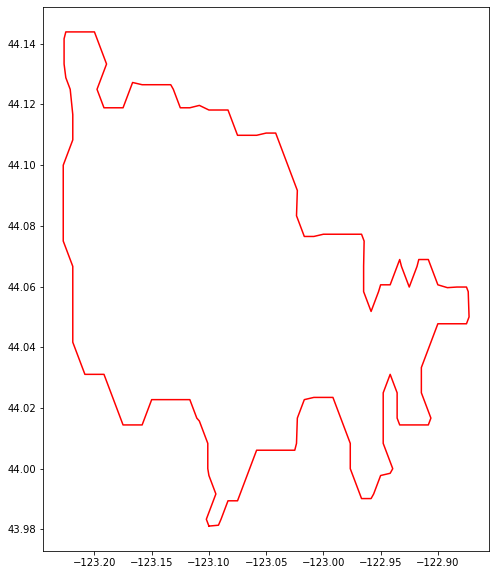

In [85]:
p2 = CS.allsegs
p1 = p2[0][:]
p1.sort(key = len , reverse=True)
poly = p1[0]
x = poly[:,0]
y = poly[:,1]



basin_poly = np.zeros((len(x),2))

for i in range(len(x)):
    basin_poly[i,0] = x[i]
    basin_poly[i,1] = y[i]
    
polygon1 = Polygon(basin_poly)
xp, yp = polygon1.exterior.xy
plt.figure(figsize=(8,10))
plt.plot(xp, yp, c="red")

evdict = {'lon':xp, 'lat':yp}
evdf = pd.DataFrame(evdict)
evdf.to_csv('/Users/rshimony/Desktop/WillametteValley/basin_south_poly.csv',index=False)

# with open('cont_poly.txt', 'w') as f:
#     for i in x:
#         for j in y:
#             f.write("%s %s\n" % (i,j))

# plt.figure()
# plt.plot(x,y)

In [ ]:
np.linalg.norm(repmat(point,len(polygon_coord)) - polygon_coord).min()

In [181]:
grid_f = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/full_grid_basin.csv')

lon_grid = grid_f['lon']
lat_grid = grid_f['lat']
depth_grid = grid_f['depth']

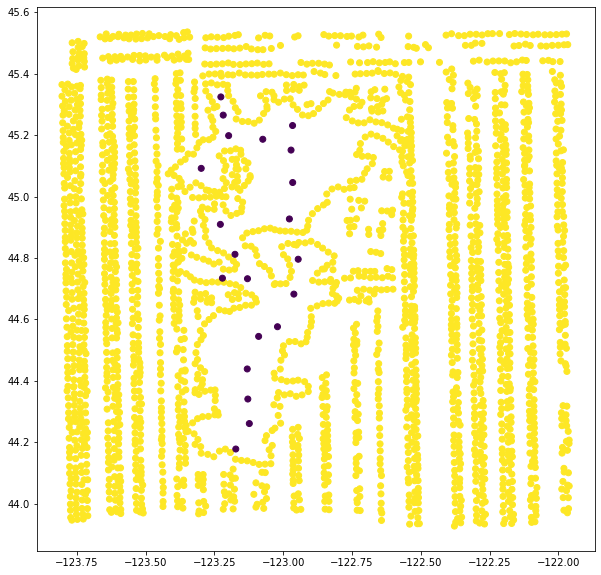

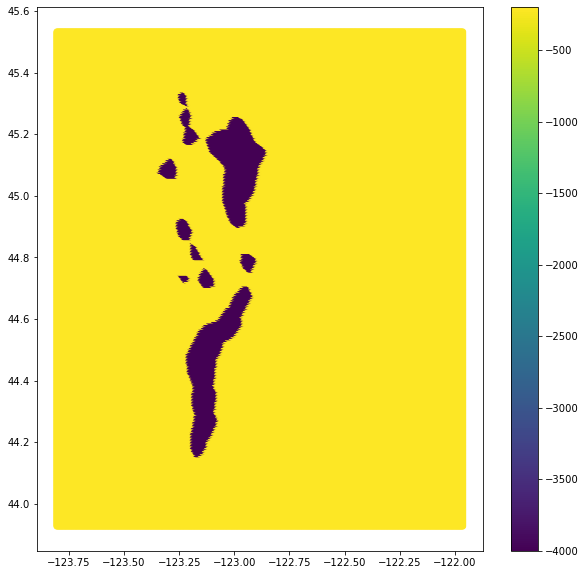

In [188]:
plt.figure(figsize=(10,10))
plt.scatter(lon_grid , lat_grid , c=depth_grid)

X = np.arange(min(lon_grid), max(lon_grid),0.005)
Y = np.arange(min(lat_grid), max(lat_grid),0.005)
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = NearestNDInterpolator(list(zip(lon_grid, lat_grid)), depth_grid)
Z = interp(X, Y)

plt.figure(figsize=(10,10))
scat = plt.scatter(X , Y , c=Z)
cb=plt.colorbar(scat)

In [8]:
# import cartopy.crs as ccrs
# from cartopy.io import srtm
# import matplotlib.pyplot as plt


# ax = plt.axes(projection=ccrs.PlateCarree())

# # Get the 1x1 degree SRTM tile for 12E, 47N
# elev, crs, extent = srtm.srtm_composite(-124.2, 43.8, 3, 2)

# # Fill the gaps present in the elevation data
# elev_filled = srtm.fill_gaps(elev, 15)

# # Add shading simulating the Sun at 10am (South-East)
# # and with a low angle (15 degrees above horizon)
# shaded = srtm.add_shading(elev_filled, 135.0, 15.0)

# # The plot the result :
# plt.imshow(shaded, extent=extent, transform=crs,
#             cmap='Greys', origin='lower')

# plt.title("SRTM Shaded Relief Map")

# gl = ax.gridlines(draw_labels=True)
# gl.xlabels_top = False
# gl.ylabels_left = False

# plt.show()



In [21]:
events = pd.read_csv('/Users/rshimony/Desktop/WillametteValley/eve_4_inv/metadata/WV_catalog.csv')
lat_ev = events['latitude']
lon_ev = events['longitude']
time = events['time']
year = []
for i in time:
    year_i = int(i[:4])
    year.append(year_i)
    
catnum = events['catalog #']

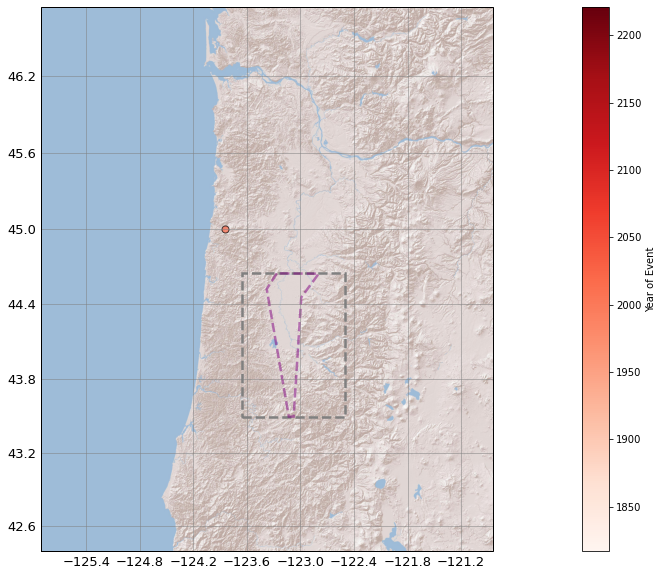

In [34]:
plt.figure(figsize=(20, 10))

ax = plt.axes(projection=ShadedReliefESRI().crs)
ax.set_extent([(min(lon_ev) - 0.05) , (max(lon_ev) + 0.05) , (min(lat_ev) - 0.05) , (max(lat_ev) + 0.05)])
ax.add_image(ShadedReliefESRI(), 10)

gl_major = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl_major.xlabels_top = False
gl_major.ylabels_right = False
gl_major.xlabel_style = {'size': 13}
gl_major.ylabel_style = {'size': 13}

scat=ax.scatter(lon_ev[50],lat_ev[50],s=50,c=year[50],cmap='Reds',alpha=0.7,transform=ccrs.PlateCarree(),edgecolors='k')
# for n in range(len(catnum)):
#     ax.text(lon_ev[n]-0.10, lat_ev[n]+0.03,str(catnum[n]), fontsize=6, color='k', transform=ccrs.PlateCarree())

cb=plt.colorbar(scat,fraction=0.035, pad=0.08)
cb.set_alpha(1)
cb.set_label('Year of Event')
cb.draw_all()
    
rect = patches.Rectangle(xy=[-123.65, 43.49], width=1.15, height=1.16,linewidth=2.5,facecolor='none'
                         ,edgecolor='grey',linestyle='--',transform=ccrs.PlateCarree())
ax.add_patch(rect)

valley_borders = patches.Polygon(xy=valley_poly,facecolor='none',edgecolor='purple',linewidth=2.5,linestyle='--',
                            alpha=0.5,transform=ccrs.PlateCarree(),zorder=1)
ax.add_patch(valley_borders)

plt.show()
# plt.savefig('/Users/rshimony/Documents/Sci_Mat/Stephenson_model/map_evs.png',dpi=600,bbox_inches='tight')

In [24]:
unit_depths = [srv_depth , yamhill_depth , spencer_depth , eugene_depth]
unit_thicks = [thickness_srv2yam , thickness_yam2spen , thickness_spen2eug , thickness_yam2eug]

unit_names = ['SRV' , 'Yamhill' , 'Spencer' , 'Eugene']

In [32]:
figw, figh = 15.0, 9.0
fig, axs = plt.subplots(2,2,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(figw,figh), 
                        sharey='row' , sharex='col')
# fig.subplots_adjust(wspace=0.5,hspace=0.1)
plt.subplots_adjust(wspace = 0.2 ,hspace = 0.15, right=0.8)

axs=axs.flatten()

for i in range(len(unit_depths)):

    axs[i].set_extent([-124.19,-121.51,43.4,46.1])
    axs[i].add_image(ShadedReliefESRI(), 10)
            
    gl_major = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, 
                            color='gray', alpha=0.5, linestyle='-')
    gl_major.xlabels_top = False
    gl_major.ylabels_right = False
    gl_major.xlabel_style = {'size': 13}
    gl_major.ylabel_style = {'size': 13}
            
    scat=axs[i].scatter(inpoly_lons,inpoly_lats,c=dists,cmap='rainbow_r',transform=ccrs.PlateCarree(),alpha=0.4 ,zorder=2)
    scat1 = axs[i].scatter(lon_units,lat_units,c=unit_depths[i],s=150 ,cmap='viridis_r',transform=ccrs.PlateCarree(), zorder=4)
    cb11=fig.colorbar(scat1,fraction=0.035, pad=0.08)
    cb11.set_label(str(unit_names[i]) + 'Depth [km]')
    
    axs[i].plot(xpn,ypn, transform=ccrs.PlateCarree() , c="k" , linewidth=3 , alpha=1)
    axs[i].plot(xph1,yph1, transform=ccrs.PlateCarree() , c="k" , linewidth=3 , alpha=1)
    axs[i].plot(xph2,yph2, transform=ccrs.PlateCarree() , c="k" , linewidth=3 , alpha=1)    
                
    axs[i].set_title(str(unit_names[i]) , pad= 22)
    
    # cb=plt.colorbar(scat,fraction=0.022, pad=0.07 , ax=axs[i])
    # cb.set_alpha(1)
    # cb.set_label(res_names[i])
    # cb.draw_all()
    fig.suptitle('Units Depth Maps', fontsize=18)
        
# plt.title('Residual Plots: Observed - Predicted (Initial Model)')
       
cbar_ax = fig.add_axes([0.85, 0.35, 0.02, 0.4])
cbar=fig.colorbar(scat, cax=cbar_ax)
cbar.set_label('Basin depth [km]',size='13')
cb.set_alpha(1) 
cb.draw_all()


plt.savefig('/Users/rshimony/Desktop/map_unit_depths.png',dpi=200,bbox_inches='tight')


plt.close('all')